In [1]:
import itertools
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Mounted at /content/gdrive


In [2]:
conn_measures = ['PAC', 'PEC', 'SC_R(1,4)', 'SC_I(1,4)', 'PLV(1,4)', 'PLI(1,4)', 'CC(1,4)', 'SC_R(4,8)', 'SC_I(4,8)', 'PLV(4,8)', 'PLI(4,8)', 'CC(4,8)', 'SC_R(8,12)', 'SC_I(8,12)', 'PLV(8,12)', 'PLI(8,12)', 'CC(8,12)', 'SC_R(13,30)', 'SC_I(13,30)', 'PLV(13,30)', 'PLI(13,30)', 'CC(13,30)', 'SC_R(30,70)', 'SC_I(30,70)', 'PLV(30,70)', 'PLI(30,70)', 'CC(30,70)', 'SC_R(70,150)', 'SC_I(70,150)', 'PLV(70,150)', 'PLI(70,150)', 'CC(70,150)']

Single connectivity measures:

WOI: NN
Connectivity: SC_R(70,150)


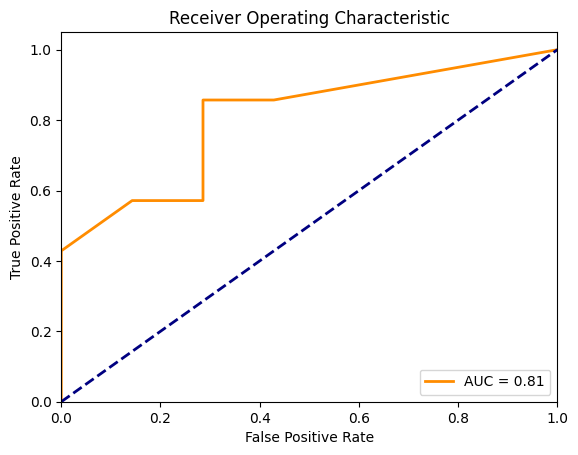

WOI: NS
Connectivity: SC_R(4,8)


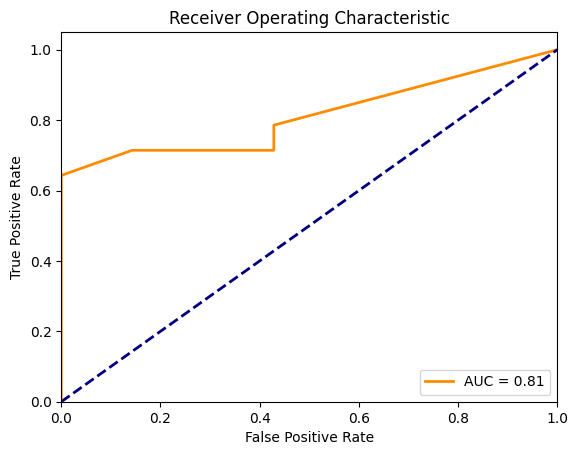

WOI: NS
Connectivity: SC_R(30,70)


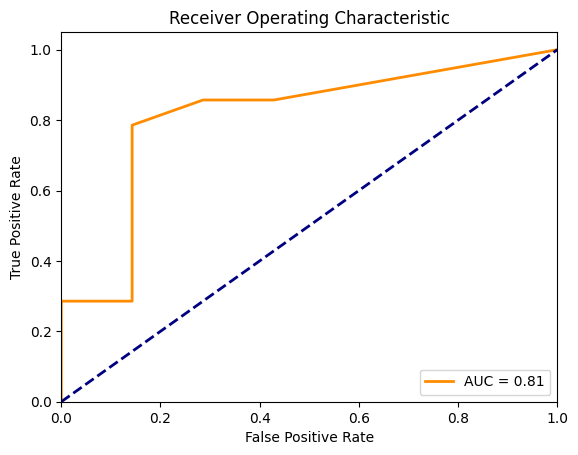

In [8]:
results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder+"results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    # Store the results in a list


    for cm in conn_measures:

        data = load_data.groupby("method").get_group(cm)

        scores, actual_labels = list(data.score1), list(data.outcome)

        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(actual_labels, scores)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Compute Youden's index
        youden_index = tpr - fpr
        best_threshold_index = np.argmax(youden_index)

        # Sensitivity and specificity at the best threshold
        sens = tpr[best_threshold_index]
        spec = 1 - fpr[best_threshold_index]

        # Print the AUC
        # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

        # Append the results to the list
        results.append({
            'WOI': woi,
            'CM': cm,
            'AUC': roc_auc,
            'Sensitivity': sens,
            'Specificity': spec
        })

        # Plot the ROC curve
        if roc_auc > 0.8:

          print(f"WOI: {woi}")
          print(f"Connectivity: {cm}")
          plt.figure()
          plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:0.2f}')
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic')
          plt.legend(loc="lower right")
          plt.show()
          plt.close()

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save the results to an Excel file
    results_df.to_excel(main_folder + "1cm_rocauc_results.xlsx", index=False)

Combinations od 2 connectivity measures:

WOI: NN
Connectivity Combination: CC(30,70), SC_R(70,150)


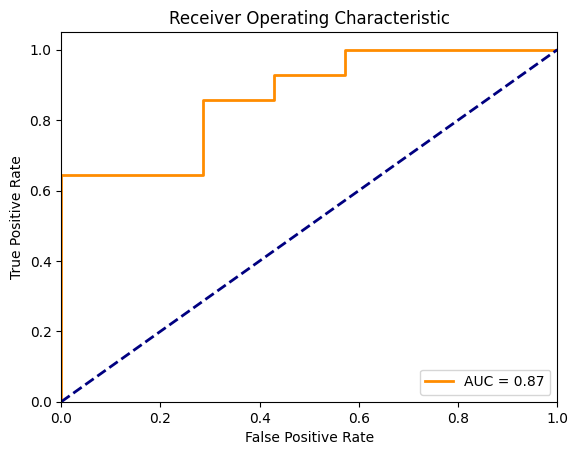

WOI: NS
Connectivity Combination: PLV(1,4), SC_R(8,12)


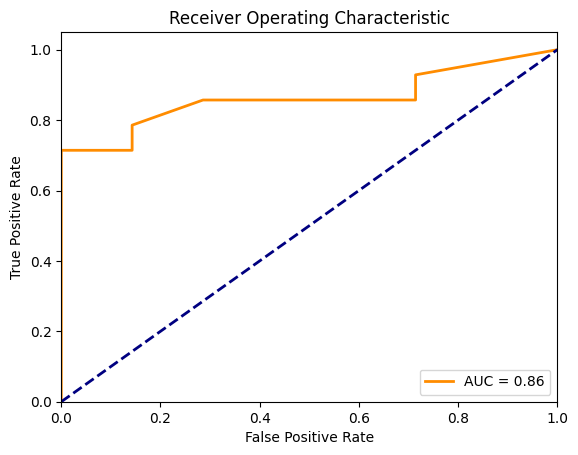

WOI: NS
Connectivity Combination: SC_R(4,8), SC_R(30,70)


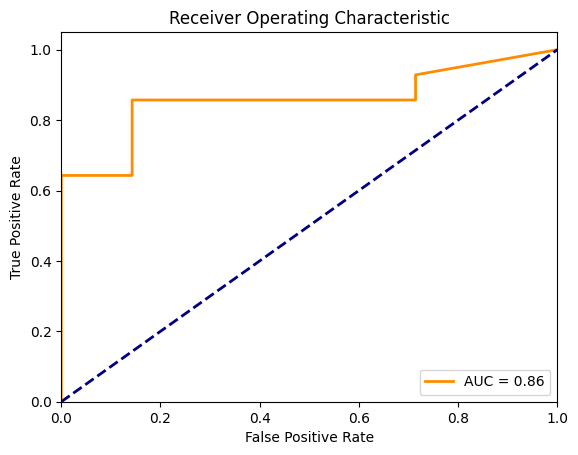

WOI: NS
Connectivity Combination: SC_R(4,8), CC(30,70)


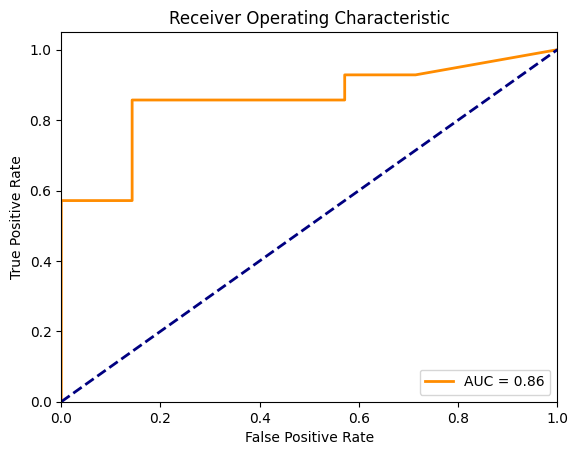

In [23]:
# Function to compute AUC, sensitivity, and specificity for a given combination of connectivity measures
def compute_metrics_for_combination(cm_combination, load_data):

    combined_scores = []
    actual_labels = None

    for cm in cm_combination:

        data = load_data[load_data['method'] == cm]
        if data['score1'].values.shape[0] == 21:
          if actual_labels is None:
              actual_labels = data['outcome'].values
          combined_scores.append(data['score1'].values)
        else: break

    if len(combined_scores) == len(cm_combination):

      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      roc_auc = auc(fpr, tpr)

      # Compute Youden's index
      youden_index = tpr - fpr
      best_threshold_index = np.argmax(youden_index)

      # Sensitivity and specificity at the best threshold
      sens = tpr[best_threshold_index]
      spec = 1 - fpr[best_threshold_index]

      return roc_auc, sens, spec

    else: return None, None, None


# Generate combinations of 2 connectivity measures
combinations = list(itertools.combinations(conn_measures, 2))

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in combinations:

        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve

          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.85:

            print(f"WOI: {woi}")
            combination_str = ', '.join(cm_combination)
            print(f"Connectivity Combination: {combination_str}")

            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "2cm_rocauc_results.xlsx", index=False)

Combinations of 3 connectivity measures:

In [ ]:
# Generate combinations of 3 connectivity measures
combinations = list(itertools.combinations(conn_measures, 3))

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in combinations:
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          plt.figure()
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.9:
              print(f"Connectivity Combination: {combination_str}")

              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('False Positive Rate')
              plt.ylabel('True Positive Rate')
              plt.title('Receiver Operating Characteristic')
              plt.legend(loc="lower right")
              plt.show()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "3cm_rocauc_results.xlsx", index=False)

<ipython-input-25-1cd47e57083e>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Combinations of 4 connectivity measures:

In [ ]:
# Generate combinations of 4 connectivity measures
combinations = [('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'), ('PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'), ('CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)'),
('PEC', 'PAC', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(1,4)'),
('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
('PEC', 'PLI(1,4)', 'PLV(4,8)', 'SC_R(1,4)'),
('PEC', 'PLI(1,4)', 'CC(13,30)', 'CC(30,70)'),
('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_I(70,150)'),
('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(1,4)'),
('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(30,70)'),
('PEC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(8,12)'),
('PEC', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PEC', 'PLV(70,150)', 'SC_I(1,4)', 'SC_R(30,70)'),
('PEC', 'CC(13,30)', 'CC(30,70)', 'SC_R(8,12)'),
('PEC', 'CC(30,70)', 'SC_I(70,150)', 'SC_R(30,70)'),
('PEC', 'CC(30,70)', 'SC_R(1,4)', 'SC_R(4,8)')]

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in combinations:
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          plt.figure()
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.8:
              print(f"Connectivity Combination: {combination_str}")
              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('False Positive Rate')
              plt.ylabel('True Positive Rate')
              plt.title('Receiver Operating Characteristic')
              plt.legend(loc="lower right")
              plt.show()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "4cm_rocauc_results.xlsx", index=False)

Combinations of 5 connectivity measures:

In [ ]:
# Generate combinations of 5 connectivity measures
combinations = [('PEC', 'PLI(1,4)', 'SC_I(8,12)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'),
('PLI(1,4)', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PLI(1,4)', 'CC(30,70)', 'SC_I(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
('PEC', 'PAC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
('PEC', 'PAC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
('PEC', 'PAC', 'PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PEC', 'PAC', 'PLI(1,4)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'PLV(1,4)', 'CC(30,70)', 'SC_R(8,12)'),
('PEC', 'PAC', 'PLV(70,150)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PEC', 'PAC', 'CC(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'SC_I(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
('PEC', 'PAC', 'SC_R(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
('PEC', 'PLI(1,4)', 'PLI(70,150)', 'SC_I(1,4)', 'SC_R(4,8)')]

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in combinations:
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          plt.figure()
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.8:
              print(f"Connectivity Combination: {combination_str}")
              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('False Positive Rate')
              plt.ylabel('True Positive Rate')
              plt.title('Receiver Operating Characteristic')
              plt.legend(loc="lower right")
              plt.show()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "5cm_rocauc_results.xlsx", index=False)

In [ ]:
import seaborn as sns

wois=["NN","N60S","NS","NE"]

xd,yd,hue=[],[],[]

for woi in wois:

    for it in range(1,6):

        f = "{}cm_rocauc_results.xlsx".format(it)

        df = pd.read_excel(main_folder+f)
        df = df[['time_frame'] == woi]
        ytemp=list(df["AUC"])
        yd+=list(ytemp)
        xd+=[str(it)]*len(ytemp)

        if woi=="NS": hue+=["transition"]*len(ytemp)
        elif woi=="N60S": hue+=["pre-seizure"]*len(ytemp)
        elif woi=="NE": hue+=["seizure"]*len(ytemp)
        elif woi=="NN": hue+=["non-seizure"]*len(ytemp)

datasorted = {"xd":xd,
      "hue_woi":hue,
      "yd":yd}

# bp=sns.boxplot(y="overlap", x="tick", data=data, palette="colorblind", width=0.5)
bp=sns.boxplot(y="yd", x="xd", data=datasorted, hue="hue_woi", palette="colorblind")
# bp=sns.stripplot(y="Result", x="Method", data=data, jitter=True, dodge=True, marker="o", alpha=0.8, hue="Outcome", color="grey")
# add_stat_annotation(bp, data=datasorted, x="xd", y="yd", hue="hue_woi",
#                                     box_pairs=[(('1',"transition"), ('1',"non-seizure")),
#                                                (('1',"transition"), ('1',"pre-seizure")),
#                                                (('1',"transition"), ('1',"seizure")),
#                                                (('2',"transition"), ('2',"non-seizure")),
#                                                (('2',"transition"), ('2',"pre-seizure")),
#                                                (('2',"transition"), ('2',"seizure")),
#                                                (('3',"transition"), ('3',"non-seizure")),
#                                                (('3',"transition"), ('3',"pre-seizure")),
#                                                (('3',"transition"), ('3',"seizure")),
#                                                (('4',"transition"), ('4',"non-seizure")),
#                                                (('4',"transition"), ('4',"pre-seizure")),
#                                                (('4',"transition"), ('4',"seizure")),
#                                                (('5',"transition"), ('5',"non-seizure")),
#                                                (('5',"transition"), ('5',"pre-seizure")),
#                                                (('5',"transition"), ('5',"seizure")),
#                                                (('1',"pre-seizure"), ('1',"non-seizure")),
#                                                (('2',"pre-seizure"), ('2',"non-seizure")),
#                                                (('3',"pre-seizure"), ('3',"non-seizure")),
#                                                (('4',"pre-seizure"), ('4',"non-seizure")),
#                                                (('5',"pre-seizure"), ('5',"non-seizure"))],
#                                     test='Mann-Whitney', text_format='star', fontsize="large", linewidth=2,
#                                     loc='inside', verbose=2)
handles, labels = bp.get_legend_handles_labels()
plt.legend(handles[0:len(wois)], labels[0:len(wois)], fontsize=24,bbox_to_anchor=(1.05, 1))
# plt.title("Network overlap", size=24)
plt.yticks(fontsize=24,rotation=90)
plt.xticks(fontsize=24)
plt.ylabel('ROC-AUC',fontsize=28)
plt.xlabel('Multiscore combination size',fontsize=28)